## Baseline Model Pipeline   

Hi, This kernel is automatically generated by the Aster - The kaggle bot to generate baseline kernels for a variety of datasets / competitions. In this kernel, I am using the given dataset for exploration, preprocessing, modelling purposes. Let me walk you through the contents of this kernel:

### Contents 

1. Environment Preparation
2. Quick Exploration   
&nbsp;&nbsp;&nbsp;&nbsp; 2.1 Dataset Preparation   
&nbsp;&nbsp;&nbsp;&nbsp; 2.2 Dataset Snapshot and Summary    
&nbsp;&nbsp;&nbsp;&nbsp; 2.3 Target Variable Distribution    
&nbsp;&nbsp;&nbsp;&nbsp; 2.4 Missing Values    
&nbsp;&nbsp;&nbsp;&nbsp; 2.5 Variable Types  
&nbsp;&nbsp;&nbsp;&nbsp; 2.6 Variable Correlations
3. Preprocessing  
&nbsp;&nbsp;&nbsp;&nbsp; 3.1 Label Encoding    
&nbsp;&nbsp;&nbsp;&nbsp; 3.2 Missing Values Treatment     
&nbsp;&nbsp;&nbsp;&nbsp; 3.3 Feature Engineering (text fields)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.1 TF-IDF Vectorizor  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3.3.2 Top Keywords - Wordcloud    
&nbsp;&nbsp;&nbsp;&nbsp; 3.4 Train Test Split    
4. Modelling   
&nbsp;&nbsp;&nbsp;&nbsp; 4.1 Logistic Regression  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2 Decision Tree    
&nbsp;&nbsp;&nbsp;&nbsp; 4.3 Random Forest  
&nbsp;&nbsp;&nbsp;&nbsp; 4.4 ExtraTrees Classifier  
&nbsp;&nbsp;&nbsp;&nbsp; 4.5 Extereme Gradient Boosting  
5. Feature Importance   
6. Model Ensembling  
&nbsp;&nbsp;&nbsp;&nbsp; 6.1 A simple Blender  
7. Creating Submission

## Step 1: Prepare Environment
As the first step, lets load all the required libraries to be used in the kernel

In [1]:
## modelling libraries
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

## preprocessing libraries
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import pandas as pd
import numpy as np 
import itertools
import os 

## visualization libraries
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns

print ("all libraries imported successfully")

all libraries imported successfully


## Step 2: Quick Exploration
In the next step, lets load the dataset into my memory and perform a quick exploratory analysis 

### 2.1 Dataset Preparation

In [60]:
## read dataset
train_path = "../input/mushrooms.csv"
train_df = pd.read_csv(train_path)
train_copy = train_df.copy()

test_path = "../input/.csv"
test_df = pd.DataFrame()
if os.path.exists(test_path):
    test_df = pd.read_csv(test_path)

print ("dataset loaded")

dataset loaded


Now, the dataset is loaded into dataframes, lets get predictor and target variables

In [61]:
## separate predictors and target variables
_target = "class"
Y = train_df[_target]
distinct_Y = Y.value_counts().index

## separate the id column
_id = ""
if _id == "": ## if id is not present, create a dummy 
    _id = "id"
    train_df[_id] = 1
    test_df[_id] = 1
if _id not in list(test_df.columns):
    test_df[_id] = 1
    
## drop the target and id columns
train_df = train_df.drop([_target, _id], axis=1)
test_id = test_df[_id]
test_df = test_df.drop([_id], axis=1)

In [62]:
## flag variables (used by bot to write the relevant code)
textcol = "text"
tag = "num"

### 2.2 Dataset snapshot and summary

Lets look at the dataset snapshot and the summary

In [63]:
## snapshot of train and test
train_df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,w,w,p,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,w,w,p,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,w,w,p,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,w,w,p,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,w,w,p,w,o,e,n,a,g


In [64]:
## summary of train and test
train_df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


### 2.3 Target variable distribution

Lets plot the distribution of target variable

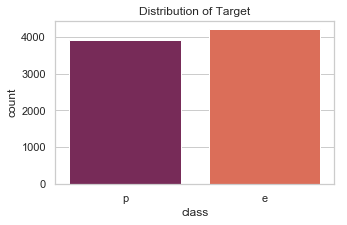

In [65]:
tar_dist = dict(Counter(Y.values))

xx = list(tar_dist.keys())
yy = list(tar_dist.values())

plt.figure(figsize=(5,3))
sns.set(style="whitegrid")
ax = sns.barplot(x=xx, y=yy, palette="rocket")
ax.set_title('Distribution of Target')
ax.set_ylabel('count');
ax.set_xlabel(_target);

lets generate some plots related to dataset

In [66]:
if tag == "doc":
    txts = []
    for i, y in enumerate(distinct_Y):
        txt = " ".join(train_copy[train_copy[_target] == y]["text"]).lower()
        txts.append(txt)

    for j, text in enumerate(txts):
        wc = WordCloud(background_color="black", max_words=2000, stopwords=STOPWORDS)
        wc.generate(text)
        plt.figure(figsize=(9,8))
        plt.axis("off")
        plt.title("Most frequent words - " + distinct_Y[j], fontsize=20)
        plt.imshow(wc.recolor(colormap= 'cool' , random_state=17), alpha=0.95)
        plt.show()

### 2.4 Missing Value Counts 

Lets check the count of missing values in the datasets 

In [67]:
mcount = train_df.isna().sum() 
xx = mcount.index 
yy = mcount.values

missing_cols = 0
for each in yy:
    if each > 0:
        missing_cols += 1
print ("there are " + str(missing_cols) + " columns in the dataset having missing values")

if missing_cols > 0:
    plt.figure(figsize=(12,5))
    sns.set(style="whitegrid")
    ax = sns.barplot(x=xx, y=yy, palette="gist_rainbow")
    ax.set_title('Number of Missing Values')
    ax.set_ylabel('Number of Columns');

there are 0 columns in the dataset having missing values


### 2.5 Variable Types

Lets count the number of numerical and categorical columns in the dataset

In [68]:
## find categorical columns in the dataset 
num_cols = train_df._get_numeric_data().columns
cat_cols = list(set(train_df.columns) - set(num_cols))

print ("There are " + str(len(num_cols)) + " numerical columns in the dataset")
print ("There are " + str(len(cat_cols)) + " object type columns in the dataset")

There are 0 numerical columns in the dataset
There are 22 object type columns in the dataset


### 2.6 Variable Correlations (Only Numerical Fields)

Lets plot the correlations among the variables. The generated graph can give an idea about features which are highly, moderately or least correlated with one another.  

In [69]:
get_corr = False
corr = train_df.corr()
if len(corr) > 0:
    get_corr = True
    colormap = plt.cm.BrBG
    plt.figure(figsize=(10,10));
    plt.title('Pearson Correlation of Features', y=1.05, size=15);
    sns.heatmap(corr, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
else:
    print ("No variables available for correlation")

No variables available for correlation


## Step 3: Data Preprocessing

In the data preprocessing step, we will perform label encoding of categorical variables and handle missing values.

### 3.1 Label Encoding
In this step, convert the categorical variables into label encoded forms

In [70]:
columns = train_df.columns
num_cols = train_df._get_numeric_data().columns
cat_cols = list(set(columns) - set(num_cols))
    
if tag == "doc":
    print ("No columns available for label encoding")
elif len(cat_cols) > 0:
    for col in cat_cols: 
        le = LabelEncoder()
        
        if col in list(test_df.columns):
            le.fit(list(train_df[col].values) + list(test_df[col].values))
        else:
            le.fit(list(train_df[col].values))
        
        train_df[col] = le.transform(list(train_df[col].values))
        try:
            test_df[col] = le.transform(list(test_df[col].values))
        except:
            pass
        
## label encode the target variable (if object type)
if Y.dtype.name == "object":
    le = LabelEncoder()
    Y = le.fit_transform(Y.values)

### 3.2 Missing Values Treatment

Handle the missing values, for continuous variables, replace by mean. For categorical variables, replace by mode

In [71]:
if tag == "doc":
    train_df[textcol] = train_df[textcol].fillna("")
    if textcol in test_df:
        test_df[textcol] = test_df[textcol].fillna("")
else:
    ## for numerical columns, replace the missing values by mean
    train_df[num_cols] = train_df[num_cols].fillna(train_df[num_cols].mean())
    try:
        test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].mean())
    except:
        pass 
    
    ## for categorical columns, replace the missing values by mode
    train_df[cat_cols] = train_df[cat_cols].fillna(train_df[cat_cols].mode())    
    try:
        test_df[cat_cols] = test_df[cat_cols].fillna(test_df[cat_cols].mode())
    except:
        pass
print ("Treated missing values in the dataset")

Treated missing values in the dataset


### 3.3 Feature Engineering (only for text fields)

In this section, we will create relevant features which can be used in the modelling

#### 3.3.1 Tf IDF features

In [72]:
if tag == "doc":
    tfidf = TfidfVectorizer(min_df=3,  max_features=None, analyzer='word', 
                            token_pattern=r'\w{1,}', stop_words = 'english')
    tfidf.fit(list(train_df[textcol].values))
    xtrain = tfidf.transform(train_df[textcol].values) 
    if textcol in test_df.columns:
        xtest = tfidf.transform(test_df[textcol].values)
else:
    xtrain = train_df
    xtest = test_df

In [73]:
if tag != "doc":
    print ("Lets plot the dataset distributions after preprocessing step ... ")
    ## pair plots
    sns.pairplot(train_df, palette="cool")
    
    ## distributions
    columns=train_df.columns
    plt.subplots(figsize=(18,15))
    length=len(columns)
    for i,j in itertools.zip_longest(columns,range(length)):
        plt.subplot((length/2),3,j+1)
        plt.subplots_adjust(wspace=0.2,hspace=0.5)
        train_df[i].hist(bins=20, edgecolor='white')
        plt.title(i)
    plt.show()

Lets plot the dataset distributions after preprocessing step ... 


KeyboardInterrupt: 

### 3.4 Train and Validation sets split

Create the training and validation sets for training the model and validating it

In [74]:
X_train, X_valid, y_train, y_valid = train_test_split(xtrain, Y, test_size=0.20, random_state=2018)

## Step 4 : Create baseline model

Next step is the modelling step, lets start with the simple linear model 

### 4.1 : Logistic Regression

Train a binary classifier logistic regression

The AUC for logistic regression is : 0.9485829326631213


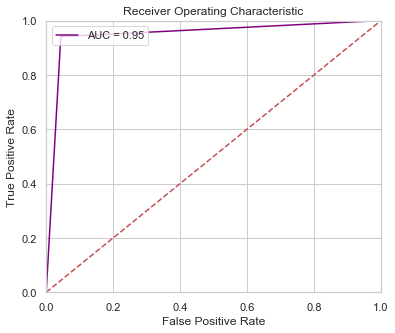

In [75]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)
valp = model1.predict(X_valid)

def generate_auc(y_valid, valp, model_name):
    auc_scr = roc_auc_score(y_valid, valp)
    print('The AUC for ' +model_name+ ' is :', auc_scr)

    fpr, tpr, thresholds = roc_curve(y_valid, valp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'purple', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'upper left')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

if len(distinct_Y) == 2:
    generate_auc(y_valid, valp, model_name="logistic regression")

<Figure size 576x576 with 0 Axes>

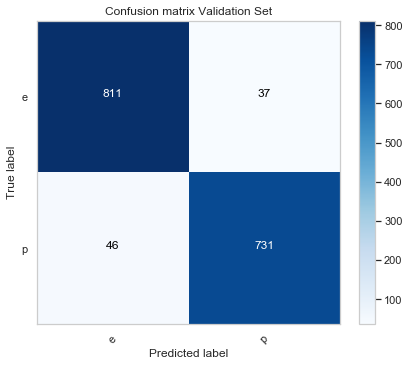

In [76]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(6,5));
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

### 4.2 : Decision Tree Classifier

Lets train a decision tree classifier

The AUC for decision tree classifier is : 1.0


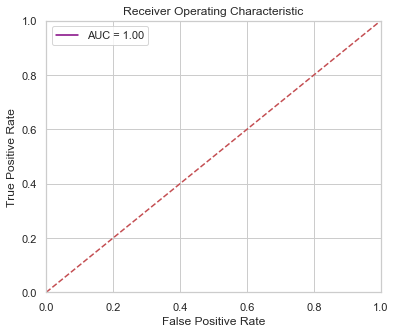

In [77]:
model2 = DecisionTreeClassifier()
model2.fit(X_train, y_train)
valp = model2.predict(X_valid)

if len(distinct_Y) == 2:
    generate_auc(y_valid,valp, model_name="decision tree classifier")

<Figure size 432x360 with 0 Axes>

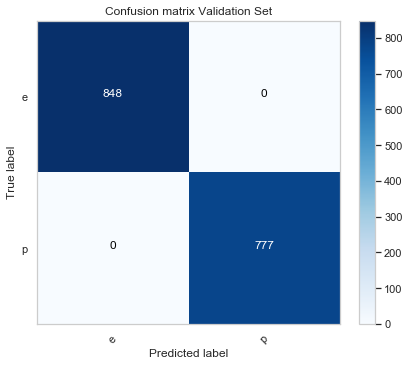

In [78]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.3 : Random Forest Classifier

Now, lets train a tree based model : random forest

The AUC for random forest classifier is : 1.0


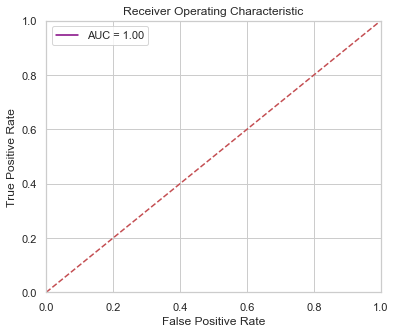

In [79]:
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)
valp = model3.predict(X_valid)

if len(distinct_Y) == 2:
    generate_auc(y_valid,valp, model_name="random forest classifier")

<Figure size 432x360 with 0 Axes>

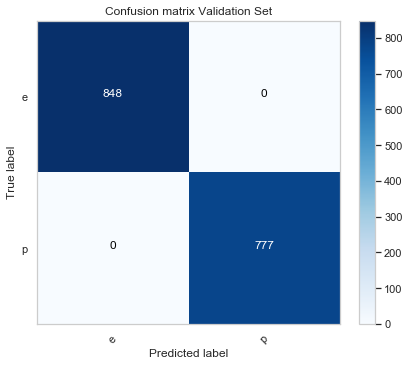

In [80]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.4 : ExtraTrees Classifier

Now, lets train another tree based model : extra trees classifier

The AUC for extratrees classifier is : 1.0


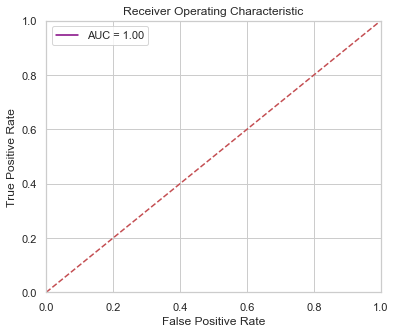

In [81]:
model4 = ExtraTreesClassifier()
model4.fit(X_train, y_train)
valp = model4.predict(X_valid)

if len(distinct_Y) == 2:
    generate_auc(y_valid,valp, model_name="extratrees classifier")

<Figure size 432x360 with 0 Axes>

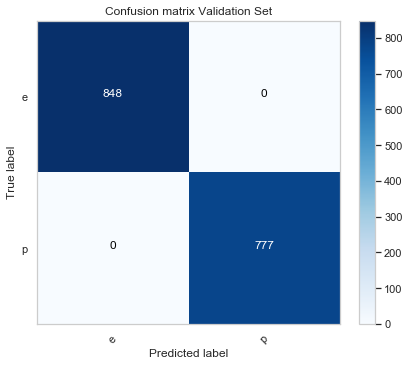

In [82]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5));
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set');
plt.show();

### 4.5 : xgBoost Classifier

Lets train the extereme gradient boosting : xgboost classifier

The AUC for xgboost is : 0.9942084942084942


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


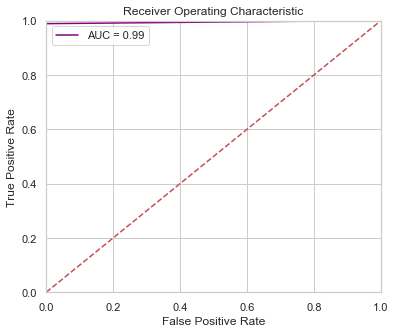

In [83]:
model5 = xgb.XGBClassifier(n_estimators=300, learning_rate=0.01)
model5.fit(X_train, y_train)
valp = model5.predict(X_valid)

if len(distinct_Y) == 2:
    generate_auc(y_valid,valp, model_name="xgboost")

<Figure size 432x360 with 0 Axes>

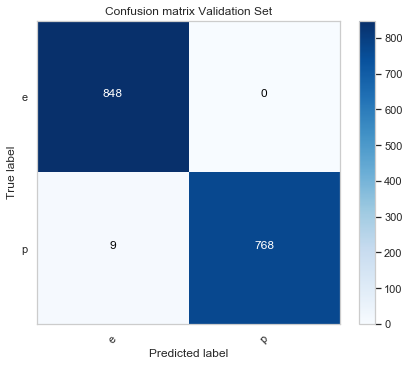

In [84]:
cnf_matrix = confusion_matrix(y_valid, valp)
np.set_printoptions(precision=2)

plt.figure(figsize=(6,5))
plot_confusion_matrix(cnf_matrix, classes=distinct_Y, title='Confusion matrix Validation Set')
plt.show()

## Step 5: Feature Importance

Lets look at some of the important features from the dataset

<Figure size 864x576 with 0 Axes>

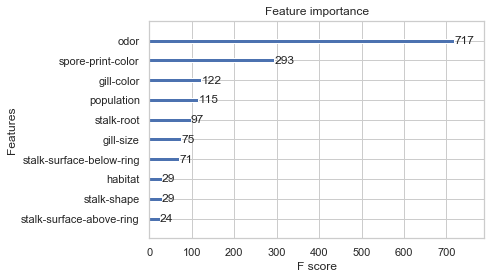

In [85]:
plt.figure(figsize=(12,8))
xgb.plot_importance(model5, max_num_features=10);

## Step 6 : Model Ensembling

Lets create a simple blender. Other options to extend are stacking / majority voting / rank averaging etc. 

In [86]:
models = [model1, model2, model3, model4, model5]
preds = np.zeros(shape=(xtest.shape[0],))
try:
    for model in models:
        pred = model.predict(xtest)/ len(models)
        preds += pred
    print (preds[:100])
except:
    print ("this is a dataset kernel, no test data for predictions")

this is a dataset kernel, no test data for predictions


## Step 7 : Create Submission File

Finally, create the submission file from the extereme graident boosting model

In [87]:
try:
    pred = model5.predict(xtest)
    sub = pd.DataFrame()
    sub[_id] = test_id
    sub[_target] = pred
    sub.to_csv("baseline_submission.csv", index=False)
    print ("Submission File Generated, here is the snapshot: ")
    print (sub.head(10))
except:
    print ("This is a dataset kernel, no need to create a submission file :)")

This is a dataset kernel, no need to create a submission file :)


Thanks for viewing this kernel, hopefully you can get ideas to start your own kernel. 